### DATASET

Qui viene importato il file *./dataset/dataset.py*, che in maniera automatica estrae l'archivio *archive.zip*. Fatto ciò assegna una label ad ogni classe in base alla cartella di appartenenza: 
<ul>
    <li>glass: 1,
    <li>paper: 2,
    <li>cardboard: 3,
    <li>plastic: 4,
    <li>metal: 5,
    <li>trash: 6.
</ul>
<br>
Infine divide l'intero dataset in training, validation e test set nella seguente proporzione:
65% per il train, il 15% per la validation e il 20% per il test.
Questi saranno richiamate nel codice a seguire.

In [19]:
import importlib
from dataset import dataset
importlib.reload(dataset)

print("Dati di training: \n", dataset.train[:10])

Dati di training: 
                                                    path  label
1100  ./dataset/garbage_dataset/Garbage classificati...      3
1289  ./dataset/garbage_dataset/Garbage classificati...      3
256   ./dataset/garbage_dataset/Garbage classificati...      4
102   ./dataset/garbage_dataset/Garbage classificati...      4
1996  ./dataset/garbage_dataset/Garbage classificati...      2
2286  ./dataset/garbage_dataset/Garbage classificati...      2
1152  ./dataset/garbage_dataset/Garbage classificati...      3
225   ./dataset/garbage_dataset/Garbage classificati...      4
142   ./dataset/garbage_dataset/Garbage classificati...      4
1541  ./dataset/garbage_dataset/Garbage classificati...      1


### PRE-PROCESSING

Ora i dati, divis nei vari set, verranno traformati tramite train_transform e test_transform: il primo si occupa di fare un resize, flip orizzontale e normalizzazione, seguendo le traformazioni applicate ai dati su cui la rete EfficientNetV2-S è stata originariamente allenata; test_transform invece fa solo un resize ed un crop centrale.

In [20]:
from src import preProcessing as pre
importlib.reload(pre)

garbage_train = dataset.CSVImageDataset('./dataset', './dataset/CSV/train.csv', transform = pre.train_transform)
garbage_valid = dataset.CSVImageDataset('./dataset', './dataset/CSV/valid.csv', transform = pre.test_transform)
garbage_test = dataset.CSVImageDataset('./dataset','./dataset/CSV/test.csv', transform = pre.test_transform)

Si creano ora dei DataLoader per i singoli set con batch pari a 32, 2 worker e i dati mescolati tramite *shuffle=True* solo per il training set.

In [21]:
from torch.utils.data import DataLoader

garbage_train_loader = DataLoader(garbage_train,  batch_size=32, num_workers=2,  shuffle=True)
garbage_valid_loader = DataLoader(garbage_valid,  batch_size=32, num_workers=2)
garbage_test_loader = DataLoader(garbage_test, batch_size=32,  num_workers=2)

Plottiamo una distribuzione delle immagini divise in base alla classe:

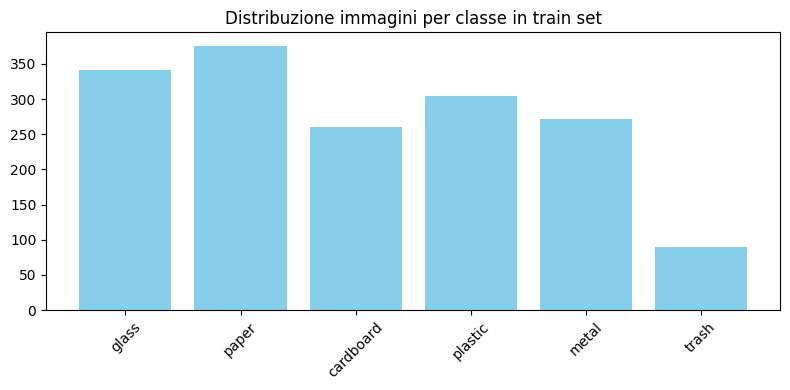

In [22]:
from src import evaluation as eval
importlib.reload(eval)

eval.plot_class_distribution(garbage_train_loader, dataset.class_dict, "Distribuzione immagini per classe in train set")

Notiamo che la classe trash è molto meno popolata rispetto alle altre, per questo aumenteremo dinamicamente i dati duplicando n (in questo caso 2) volte i campioni della classe trash nel training set.

In [23]:
garbage_train_loader = pre.data_augumentation(garbage_train, 5, garbage_train_loader, 2, 32)

È ora possibile notare come le classi risultano essere numericamente più equilibrate tra loro.

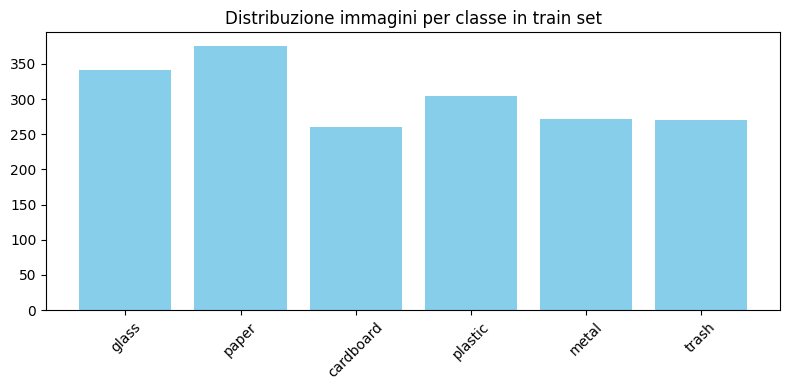

In [24]:
eval.plot_class_distribution(garbage_train_loader, dataset.class_dict, "Distribuzione immagini per classe in train set")

### TRAINING

Si è poi passati alla fase di training, grazie alla funzione ad hoc *train_validate* del modulo classifier: essa si occupa di effettuare  un numero predefinito di epoche di training, con la possibilità di inserire early stopping e dropout nel frattempo; ogni due epoche si occupa anche di salvare un checkpoint del modello, così come lo stato del modello migliore ottenuto.


Per semplicitá, verrá spiegato come si è fatto training, testing ed evaluation del migliore dei 4 esperimenti effettuati.

In [25]:
from src import classifier
importlib.reload(classifier)

title = f"runs/garbage_best_model"

In [26]:
trained_model = classifier.train_validate(
        garbage_train_loader = garbage_train_loader,
        garbage_valid_loader = garbage_valid_loader,
        log_dir=title,
        early_stop=0, dropout = True,
        epochs       = 1,
        lr           = 1e-3,
        momentum     = 0.9,
        device       = pre.device,
        log_every    = 20,
        resume_from='./savings/checkpoint_epoch20.pth'
)

Ripreso da: ./savings/checkpoint_epoch20.pth | epoca 21 | best_acc: 0.926
Miglior accuratezza validazione: 0.9261213720316622


In [27]:
model = classifier.load_model('./savings/best_model_dropout.pt', pre.device)

Dopo aver caricato il modello, possiamo effettuarne una valutazione attraverso:
<ul>
<li> confusion matrix;
<li> accuracy;
<li> precision;
<li> recall;
<li> f1 score.
</ul>
Queste funzioni sono definite nel modulo <i> evaluation</i>.

In [28]:
acc, prec, rec, f1, cm = eval.evaluate(model, garbage_valid_loader, pre.device, target_names=['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash'])

Accuracy     : 0.9868
Precision    : 0.9872
Recall       : 0.9868
F1 Score     : 0.9868

 Confusion Matrix:
[[72  0  0  0  0  0]
 [ 0 99  1  0  1  0]
 [ 0  0 55  0  0  0]
 [ 2  0  0 82  0  0]
 [ 0  0  0  0 51  0]
 [ 1  0  0  0  0 15]]

 Classification Report:
              precision    recall  f1-score   support

       glass       0.96      1.00      0.98        72
       paper       1.00      0.98      0.99       101
   cardboard       0.98      1.00      0.99        55
     plastic       1.00      0.98      0.99        84
       metal       0.98      1.00      0.99        51
       trash       1.00      0.94      0.97        16

    accuracy                           0.99       379
   macro avg       0.99      0.98      0.98       379
weighted avg       0.99      0.99      0.99       379



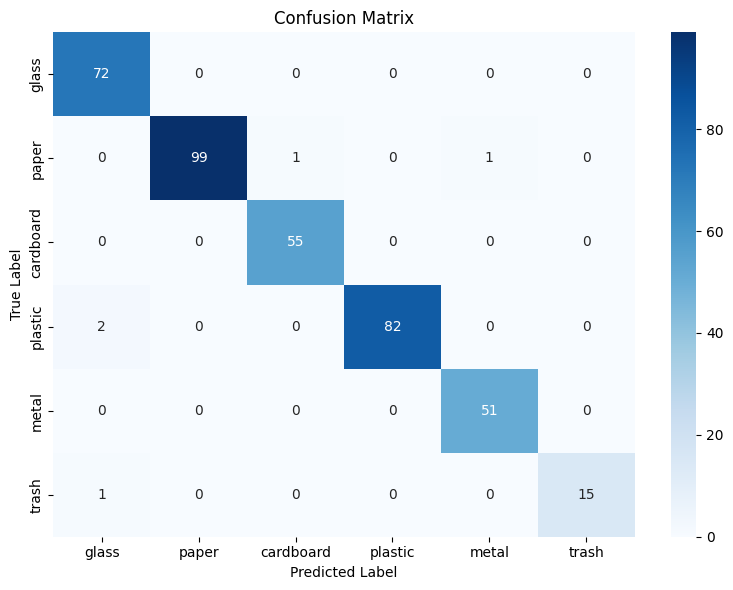

In [29]:
eval.plot_confusion_matrix(model, garbage_valid_loader, class_names=['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash'], device=pre.device)

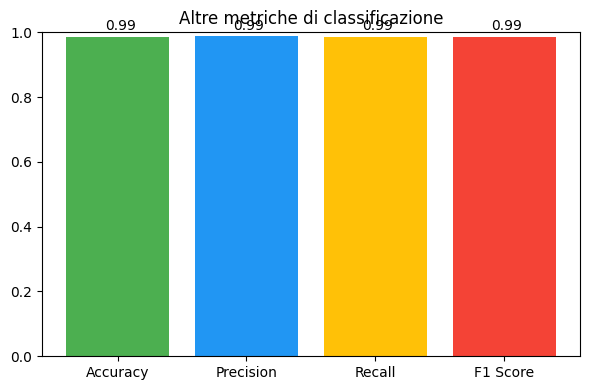

In [30]:
eval.plot_metrics_bar(acc, prec, rec, f1)

### TEST

Infine si è passati alla fase di testing e relative valutazioni attraverso le stesse metriche di cui sopra.
Per fare ciò è stata utilizzata la funzione *test_model* del modulo classifier, a cui è stato passato il DataLoader dei dati di test, unitamente al path del best_model.

Modello caricato da: ./savings/best_model_dropout.pt

 Accuracy sul test set: 0.9783

Classification Report:
              precision    recall  f1-score   support

       glass       0.99      1.00      0.99        88
       paper       1.00      0.97      0.99       117
   cardboard       0.97      1.00      0.98        88
     plastic       0.96      0.96      0.96        94
       metal       0.99      0.98      0.98        88
       trash       0.94      0.94      0.94        31

    accuracy                           0.98       506
   macro avg       0.97      0.97      0.97       506
weighted avg       0.98      0.98      0.98       506



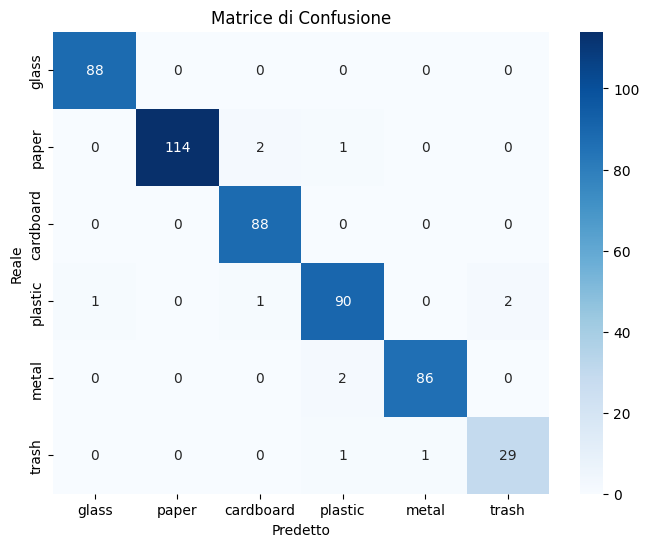

In [31]:
classifier.test_model(model, garbage_test_loader, "./savings/best_model_dropout.pt", device=pre.device, class_names=['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash'])